In [2]:
## Enviroment Setup
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Set the visible CUDA, here we use the second GPU
WORKING_DIR = '/home/peizhi/Documents/gaussian-dejavu/'
os.chdir(WORKING_DIR) # change the working directory to the project's absolute path
print("Current Working Directory: ", os.getcwd())
sys.path.append(WORKING_DIR)
sys.path.append('./models')
sys.path.append('./networks')
sys.path.append('./utils')
sys.path.append('./utils/flame_lib/')
sys.path.append('./utils/diff-gaussian-rasterization')
sys.path.append('./utils/gaussian_renderer')
sys.path.append('./utils/scene')
sys.path.append('./utils/arguments')
sys.path.append('./utils/simple-knn')

import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

import numpy as np
import cv2
import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision.transforms import Resize
# import math
# from torch.optim.lr_scheduler import StepLR

# # Dejavu
# from models.gaussian_dejavu_base import Framework
# from utils.loss import *
# from utils.scene.cameras import PerspectiveCamera, prepare_camera
# from utils.viewer_utils import OrbitCamera
# from utils.gaussian_renderer import render
# from utils.graphics_utils import create_diff_world_to_view_matrix, verts_clip_to_ndc
# from utils.loss_utils import *

# ## FLAME
# from utils.flame_lib import dict2obj
# from utils.flame_lib.FLAME import FLAME



# GUI
from ipywidgets import interactive, interact, Layout
from ipywidgets import FloatSlider
from ipywidgets import IntSlider
from ipywidgets import HBox, VBox, Label, Button


from dejavu import GaussianDejavu
from utils.personal_video_utils import *

def min_max_normalize(image):
    norm_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return norm_image

dejavu = GaussianDejavu(network_weights='./models/dejavu_network.pt', uv_map_size=120, num_expressions=20)

device = dejavu.device

Current Working Directory:  /home/peizhi/Documents/gaussian-dejavu
creating the FLAME Decoder
Framework v3.1 initialized.
Number of Gaussians:  10694
model loaded from:  ./models/dejavu_network.pt
Gaussian DejaVu Framework Created.


## Personal Data Loader

Number of frames: 4558.
img torch.Size([3, 512, 512, 3])
parsing (3, 512, 512)
vertices (3, 5023, 3)
shape torch.Size([3, 100])
exp torch.Size([3, 50])
pose torch.Size([3, 6])
eye_pose torch.Size([3, 6])
tex torch.Size([3, 50])
light torch.Size([3, 9, 3])
cam torch.Size([3, 6])
img_masked torch.Size([3, 512, 512, 3])
masks torch.Size([3, 512, 512, 1])


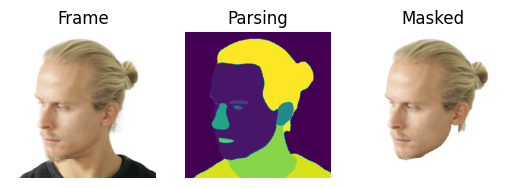

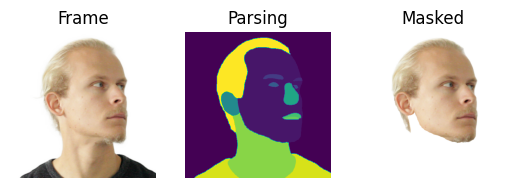

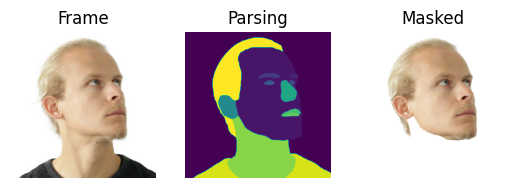

In [3]:
# Please first follow the flame-head-tracker to reconstruct the FLAME parameters  
# https://github.com/PeizhiYan/flame-head-tracker

#dataset_path = '/mnt/data3_hdd/peizhi/Datasets/Personal_Videos_flame_new/peizhi-demo'
#dataset_path = '/mnt/data3_hdd/peizhi/Datasets/IMAvatar_flame_new/subject1'
dataset_path = '/mnt/data3_hdd/peizhi/Datasets/IMAvatar_flame_new/subject2'
personal_dataloader = PersonalDataLoader(dataset_path=dataset_path, device=device, shuffle=True)

batch_data = personal_dataloader.next_random_batch(batch_size=3)

for key in batch_data:
    try:
        print(key, batch_data[key].shape)
    except:
        pass

for i in range(len(batch_data['fid'])):    
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(batch_data['img'][i].detach().cpu()); plt.axis('off'); plt.title('Frame')
    plt.subplot(1,3,2)
    plt.imshow(batch_data['parsing'][i]); plt.axis('off'); plt.title('Parsing')
    plt.subplot(1,3,3)
    plt.imshow(batch_data['img_masked'][i].detach().cpu()); plt.axis('off'); plt.title('Masked')
    plt.show()



## Train

In [15]:
dejavu.personal_video_training(personal_dataloader, batch_size=16, stage_1_steps=300, stage_2_steps=500)


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


Loss: 0.0100 LR: 0.0024: 100%|██████████| 300/300 [04:31<00:00,  1.11it/s]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


Loss: 0.0222 LR: 0.0328: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


## Compare Results

/home/peizhi/Documents/gaussian-dejavu/utils/scene/cameras.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  world_view_transform = torch.tensor(cam.world_view_transform).float().to(device)
/home/peizhi/Documents/gaussian-dejavu/utils/scene/cameras.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_proj_transform = torch.tensor(cam.full_proj_transform).float().to(device)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

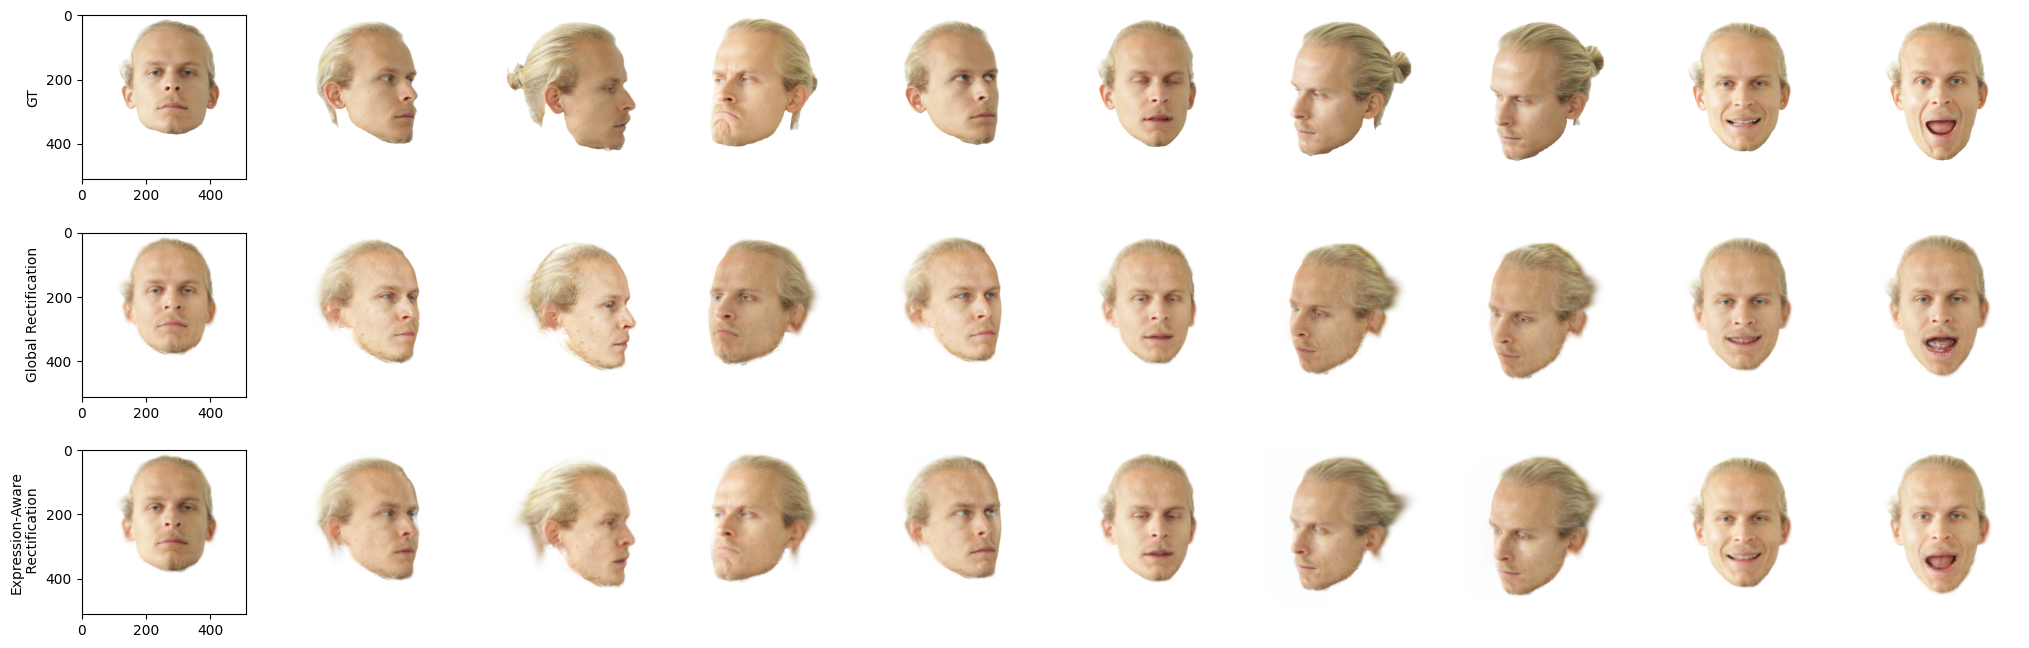

In [5]:

plt.figure(figsize=(25,8))

num_examples = 10
for i in range(num_examples):
    batch_data_test = personal_dataloader.next_random_batch(vid=None, batch_size=1)

    # Ground-Truth Frames (First Row)
    plt.subplot(3,num_examples,i+1)
    plt.imshow(batch_data_test['img_masked'][0].detach().cpu()); plt.axis('off')
    if i == 0: plt.axis('on'); plt.ylabel('GT')

    # Reconstructed, w/ Global Rectification (Second Row)
    plt.subplot(3,num_examples,num_examples+i+1)
    batch_rendered_global = dejavu._render_with_global_offsets_(batch_data_test, dejavu.global_uv_delta)
    plt.imshow(batch_rendered_global[0].detach().cpu().permute(1,2,0)); plt.axis('off')
    if i == 0: plt.axis('on'); plt.ylabel('Global Rectification')

    # Reconstructed, w/ Expression-Aware Rectification (Third Row)
    plt.subplot(3,num_examples,2*num_examples+i+1)
    batch_rendered_blend, _ = dejavu._render_with_blendmaps_(batch_data_test, dejavu.uv_delta_blendmaps)
    plt.imshow(batch_rendered_blend[0].detach().cpu().permute(1,2,0)); plt.axis('off')
    if i == 0: plt.axis('on'); plt.ylabel('Expression-Aware\n Rectification')

plt.show()



## Save Head Avatar

In [ ]:
## save head avatar

#dejavu.save_head_avatar(save_path='./saved_avatars', avatar_name='peizhi')
#dejavu.save_head_avatar(save_path='./saved_avatars', avatar_name='imavatar-subject1')
#dejavu.save_head_avatar(save_path='./saved_avatars', avatar_name='imavatar-subject2')


Head avatar parameters saved to ./saved_avatars/imavatar-subject2


## Load Head Avatar

In [4]:
## load head avatar

#dejavu.load_head_avatar(save_path='./saved_avatars', avatar_name='peizhi')
#dejavu.load_head_avatar(save_path='./saved_avatars', avatar_name='imavatar-subject1')
dejavu.load_head_avatar(save_path='./saved_avatars', avatar_name='imavatar-subject2')


Head avatar parameters loaded


# Interactive Demo


In [ ]:
# GUI
from ipywidgets import interactive, interact, Layout
from ipywidgets import FloatSlider
from ipywidgets import IntSlider
from ipywidgets import HBox, VBox, Label, Button
import math


def compute_camera_offsets(yaw, pitch, radius):
    # orbit camera function
    dx = math.sin(yaw) * radius * 0.9       # * 0.9 to hide part of the back of head
    dy = - math.sin(pitch) * radius * 0.9   # * 0.9 to hide part of the back of head
    dz_a = radius - math.cos(yaw) * radius
    dz_b = radius - math.cos(pitch) * radius
    dz = dz_a + dz_b
    return dx, dy, dz

#video_id = 'MVI_1814'
videos = list(personal_dataloader.meta_data.keys())

n_expressions = 20
prev_video_id = 0
prev_frame_id = 0
frame_indices = sorted(list(personal_dataloader.meta_data[videos[0]].keys()), key=int)
batch_data = personal_dataloader.batch_from_frame_ids(vid=videos[0], frame_ids=[frame_indices[0]])
@torch.no_grad()
def interactive_vis(**kwargs):
    global prev_video_id, prev_frame_id, frame_indices, videos, batch_data

    video_id = kwargs['video_id']            # input sample index
    frame_id = kwargs['frame_id']            # input sample index
    frame_indices = sorted(list(personal_dataloader.meta_data[videos[video_id]].keys()), key=int)
    if frame_id != prev_frame_id or video_id != prev_video_id:
        prev_frame_id = frame_id
        prev_video_id = video_id
        batch_data = personal_dataloader.batch_from_frame_ids(vid=videos[video_id], frame_ids=[frame_indices[frame_id]])

    exp = batch_data['exp'][:,:n_expressions]
    cam = batch_data['cam']
    jaw = batch_data['pose'][:,3:]

    # get initial UV maps from reconstructed FLAME
    uv_maps = dejavu.framework.create_init_uv_maps(batch_data['vertices']) # [N, S, S, 13]
    
    # create a copy of the mean uv offsets
    mean_uv_offsets_copy = torch.clone(dejavu.mean_uv_offsets) # [1, S, S, 13]
    
    # predict the uv delta maps
    uv_delta_blended = uv_delta_blending(uv_delta_weights, exp, cam, jaw)
    batch_uv_delta = uv_delta_blended   

    
    # renderer setting
    render_size = 2**kwargs['render_scale']
    framework.set_render_size(render_size)

    batch_rendered_1 = render_with_delta(framework, batch_data, mean_uv_offsets)
    batch_rendered_2 = render_with_delta(framework, batch_data, mean_uv_offsets, uv_delta)
    batch_rendered_3 = render_with_delta(framework, batch_data, mean_uv_offsets, batch_uv_delta)


    # display
    plt.figure(figsize=(15,5))
    plt.subplot(1,4,1)
    plt.imshow(batch_data['img_masked'][0].cpu()); plt.axis('off')
    plt.title(f'Target Image')
    plt.subplot(1,4,2)
    plt.imshow(np.clip(batch_rendered_1[0].cpu().detach().permute(1,2,0), 0, 1)); plt.axis('off')
    plt.title(f'Single-Image Global Reconstruction\n({render_size}x{render_size})')
    plt.subplot(1,4,3)
    plt.imshow(np.clip(batch_rendered_2[0].cpu().detach().permute(1,2,0), 0, 1)); plt.axis('off')
    plt.title(f'Global UV Rectification')
    plt.subplot(1,4,4)
    plt.imshow(np.clip(batch_rendered_3[0].cpu().detach().permute(1,2,0), 0, 1)); plt.axis('off')
    plt.title(f'Blending UV Rectification')
    plt.show()



# UI sliders
sliders = {
    #'scale_modifier': FloatSlider(value=1.0, min=0.001, max=1.0, step=0.001,readout_format='.3f',continuous_update=True),
    #'loc_discount': FloatSlider(value=0.01, min=0.0, max=0.01, step=0.001,readout_format='.3f',continuous_update=True),
    'render_scale': IntSlider(value=10, min=5, max=10, step=1,continuous_update=True), # blending rendered mesh and gaussians
    'frame_id': IntSlider(value=0, min=0, max=3100, step=1,continuous_update=True), 
    'video_id': IntSlider(value=0, min=0, max=len(videos), step=1,continuous_update=True), 
    'yaw': FloatSlider(value=0, min=-3.14/2, max=3.14/2, step=0.01,readout_format='.1f',continuous_update=True),
    'pitch': FloatSlider(value=0, min=-3.14/4, max=3.14/4, step=0.01,readout_format='.1f',continuous_update=True),
    'fov': FloatSlider(value=20, min=1, max=30, step=1,readout_format='.1f',continuous_update=True), # only for perspective projection
    'radius': FloatSlider(value=0.8, min=0.1, max=1, step=0.01,readout_format='.1f',continuous_update=True),
    #'expr_idx': IntSlider(value=1, min=1, max=len(list(example_expr_params.keys())), step=1,continuous_update=True), 
    #'expr_interpolate': FloatSlider(value=0, min=0, max=1.0, step=0.01,continuous_update=True), 
}

def reset_cam_pose(b):
    sliders['yaw'].value = 0  # Default value
    sliders['pitch'].value = 0  # Default value
    sliders['radius'].value = 0.8  # Default value

widget = interactive(interactive_vis, **sliders)

ui_ctrl_group_1 = VBox([sliders[key] for key in ['render_scale']])
ui_ctrl_group_2 = VBox([sliders[key] for key in ['yaw', 'pitch', 'fov', 'radius']])
ui_ctrl_group_3 = VBox([sliders[key] for key in ['video_id', 'frame_id']])

reset_cam_pose_btn = Button(description="Reset Camera Pose")
reset_cam_pose_btn.on_click(reset_cam_pose)

controls = HBox([ui_ctrl_group_1, 
                 ui_ctrl_group_2, 
                 ui_ctrl_group_3], layout = Layout(flex_flow='row wrap'))

output = HBox([widget.children[-1], reset_cam_pose_btn], layout = Layout(flex_flow='row wrap', align_items='center'))

display(VBox([controls, output]))
